In [1]:
!pip install git+https://github.com/styalai/xLSTM-pytorch
!pip install lightning
#!pip install datasets

  Cloning https://github.com/styalai/xLSTM-pytorch to /tmp/pip-req-build-mdw1voy7
  Running command git clone --filter=blob:none --quiet https://github.com/styalai/xLSTM-pytorch /tmp/pip-req-build-mdw1voy7
  Resolved https://github.com/styalai/xLSTM-pytorch to commit 4d47bf13afafacd329acc4fb390dbe5d9cd4d39d
  Preparing metadata (setup.py) ... done
  Created wheel for xlstm_pytorch: filename=xlstm_pytorch-1.0-py3-none-any.whl size=5162 sha256=d0577e9e32bde3dcde7b0ba88f7fa6e430bdd0d76b681eb7459d484556a3777e
  Stored in directory: /tmp/pip-ephem-wheel-cache-q1yc1qhj/wheels/20/bc/62/d205c72c2db3d41ead444506c6a8cd37de2ed8ef0ca2b3f45f
Successfully built xlstm_pytorch
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.1/54.1 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 37.6 MB/s eta 0:00:0000:01


In [2]:
import time
import torch
import torch.nn as nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import numpy as np
from math import *
from datasets import Dataset, load_dataset
import lightning as L
import csv
import os
import pandas as pd

import random
from transformers import AutoTokenizer, AutoModelForCausalLM
from huggingface_hub import PyTorchModelHubMixin
from tokenizers import ByteLevelBPETokenizer
from transformers import RobertaTokenizerFast
from xLSTM.xLSTM import xLSTM as xlstm

In [9]:
from huggingface_hub import notebook_login
# 
notebook_login()

In [8]:
def prepare_alpaca():################# ok
    dataset = load_dataset("yahma/alpaca-cleaned")
    dataset = dataset['train']
    print(dataset)
    data = {"text":[]}
    for i in tqdm(range(int(len(dataset['output'])/5 ))):
        user = "<|user|>"+ dataset['instruction'][i]+"\n"+dataset['input'][i] +"<|end|>\n"
        llm = "<|assistant|>"+ dataset['output'][i] +"<|endoftext|>"
        prompt = user+llm
        data["text"].append(prompt)

    data = pd.DataFrame.from_dict(data)
    data = Dataset.from_pandas(data)
    data.push_to_hub("styalai/alpaca-cleaned-10")
  
def prepare_ultrachat():################# ok
    dataset = load_dataset("nampdn-ai/mini-ultrachat", split='train')['data']
    print(dataset)
    data = {"text":[]}
    for i in tqdm(range(int(len(dataset)/10))):
        user = "<|user|>"+ dataset[i][0] +"<|end|>\n"
        llm = "<|assistant|>"+ dataset[i][1] +"<|endoftext|>"
        text = user+llm
        data["text"].append(text)

    data = pd.DataFrame.from_dict(data)
    data = Dataset.from_pandas(data)
    data.push_to_hub("styalai/mini-ultrachat-10")

    
def prepare_small_openorca():
    dataset = load_dataset("ashercn97/OpenOrcaSmaller2", split='train')
    print(dataset)
    data = {"text":[]}
    for i in tqdm(range(int(len(dataset["instruction"])/100))):
        user = "<|system|>"+ dataset['instruction'][i] +"<|end|>\n" +"<|user|>"+ dataset['input'][i] +"<|end|>\n"
        llm = "<|assistant|>"+ dataset['output'][i] +"<|endoftext|>"
        text = user+llm
        data["text"].append(text)

    data = pd.DataFrame.from_dict(data)
    data = Dataset.from_pandas(data)
    data.push_to_hub("styalai/small-open-orca-100")

    
def prepare_rag_dataset(): ################# ok
    dataset = load_dataset("neural-bridge/rag-dataset-1200", split='train')
    print(dataset)
    data = {"text":[]}
    for i in tqdm(range(int(len(dataset["context"])))):
        user = "<|context|>"+ dataset['context'][i] +"<|end|>\n" +"<|user|>"+ dataset['question'][i] +"<|end|>\n"
        llm = "<|assistant|>"+ dataset['answer'][i] +"<|endoftext|>"
        text = user+llm
        data["text"].append(text)

    data = pd.DataFrame.from_dict(data)
    data = Dataset.from_pandas(data)
    data.push_to_hub("styalai/rag-dataset")

    
def prepare_mmlu(): ################ ok 100=>998 row
    dataset = load_dataset("cais/mmlu", 'all', split='auxiliary_train')
    print(dataset)
    data = {"text":[]}
    for i in tqdm(range(int(len(dataset["question"])/100))):
        choices = '\n'.join(dataset['choices'][i])
        user = "<|user|>"+ dataset['question'][i] + "\n" + choices + "<|end|>\n"
        llm = "<|assistant|>"+ str(dataset['answer'][i]) +"<|endoftext|>"
        text = user+llm
        data["text"].append(text)

    data = pd.DataFrame.from_dict(data)
    data = Dataset.from_pandas(data)
    data.push_to_hub("styalai/mmlu-100")

    
def prepare_truthful_qa(): ############## ok
    dataset = load_dataset("truthfulqa/truthful_qa", "generation",split="validation")
    print(dataset)
    data = {"text":[]}
    for i in tqdm(range(int(len(dataset["question"])))):
        user = "<|user|>"+ dataset['question'][i] + "<|end|>\n"
        llm = "<|assistant|>"+ dataset['best_answer'][i] +"<|endoftext|>"
        text = user+llm
        data["text"].append(text)

    data = pd.DataFrame.from_dict(data)
    data = Dataset.from_pandas(data)
    data.push_to_hub("styalai/truthful_qa")


def prepare_chatbor_arena():
    pass


In [3]:
def get_batchs(dataset, tokenizer, block_size, batch_size):
    selects = []
    Y = []
    while len(selects) <= batch_size:
        print(len(selects))
        batchs = []
        [batchs.append(random.randint(0, len(dataset)-1)) for i in range(batch_size)]

        for b in tqdm(batchs):
          text = dataset[b]
          tokens = tokenizer(text)['input_ids']

          idx = random.randint(0, len(tokens)-2)
          select = tokens[idx-block_size:idx]
          y = tokens[idx-block_size+1:idx+1]
          if len(select) == block_size:
            selects.append(select)
            Y.append(y)

    while len(selects) > batch_size:
        del selects[0]
        del Y[0]

    X = torch.tensor(selects)
    Y = torch.tensor(Y)

    return X, Y

class DatasetTxt(torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y

    def __len__(self):
        return len(self.x)

    def __getitem__(self, index):
        sample_x = self.x[index]
        sample_y = self.y[index]
        return sample_x, sample_y


class DatasetFromHF(torch.utils.data.Dataset):
    def __init__(self, dataset, block_size, tokenizer):
        self.dataset = dataset
        self.block_size = block_size
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, index):

        tokens = tokenizer(self.dataset[index])['input_ids']
        
        X = tokens[0:self.block_size]
        Y = tokens[1:self.block_size+1]
        
        x_m = self.block_size-len(X)
        x_m = [0]*x_m
        X = x_m+X
        
        y_m = self.block_size-len(Y)
        y_m = [0]*y_m
        Y = y_m+Y
        
        return torch.tensor(X), torch.tensor(Y)

    
def train_tokenizer(vocab_size, file, path):
    tokenizer = ByteLevelBPETokenizer()
    tokenizer.train(files=file, vocab_size=vocab_size, min_frequency=2)
    
    try:
        os.mkdir("/kaggle/working/tokenizer_model")
    except:
        pass
    tokenizer.save_model('tokenizer_model')
    tokenizer = RobertaTokenizerFast.from_pretrained('tokenizer_model')
    tokenizer.bos_token = "<|user|>"
    tokenizer.eos_token = "<|end|>"
    tokenizer.add_special_tokens({"eos_token":"<|endoftext|>","bos_token":"<|user|>", "sep_token":"<|end|>"},
                                {"bos_token":"<s>", "eos_token":"</s>", "sep_token":"</s>"})
    tokenizer.add_tokens(["<|assistant|>"])
    tokenizer.add_tokens(["<|system|>"])
    tokenizer.add_tokens(["<|context|>"])
    tokenizer.push_to_hub(path)


In [8]:
####### TRAIN TOKENIZER
def create_txt(path):
    dataset = load_dataset("ChristophSchuhmann/basic-math-problems-with-step-by-step-solutions")['train']['problem+solution'][:50000]
    text = ""
    for i in dataset:
        text += i
    with open(path, 'w') as f:
        f.write(text)

#create_txt("textfile.txt")
#train_tokenizer(8000, "textfile.txt", "styalai/tokenizer-XTmath-8_000")


Resolving data files:   0%|          | 0/129 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/12025722 [00:00<?, ? examples/s]

Loading dataset shards:   0%|          | 0/22 [00:00<?, ?it/s]

In [4]:
class Head(nn.Module):
    """one head of self-attention"""

    def __init__(self, head_size, n_embd, block_size, dropout):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))

        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
            B,T,C = x.shape
            k = self.key(x)
            q = self.query(x)
            # compute attention score ("affinities")
            wei = q @ k.transpose(-2, -1) * C**-0.5
            wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf')) # (B, T, T)
            wei = F.softmax(wei, dim=-1)# (B, T, T)
            wei = self.dropout(wei)
            # perform the weighted aggregation of the values
            v = self.value(x)
            out = wei @ v # (B, T, C)
            return out

class MultiHeadAttention(nn.Module):
    """multiple heads of self-attention in parallel"""

    def __init__(self, head_size, n_head, n_embd, dropout):
        super().__init__()

        self.heads = nn.ModuleList([Head(head_size, n_embd, block_size, dropout) for _ in range(n_head)])
        self.proj = nn.Linear(n_head * head_size, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embd, dropout):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )
    def forward(self, x):
        x = self.net(x)
        return x


class Block(nn.Module):
    """ Transformer block: communication followed by computation"""

    def __init__(self, transformer_config):
        super().__init__()
        dropout = transformer_config['dropout']
        n_embd = transformer_config['n_embd']
        n_head = transformer_config['n_head']
        head_size = n_embd // n_head

        self.sa = MultiHeadAttention(head_size, n_head, n_embd, dropout)
        self.ffwd = FeedForward(n_embd, dropout)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class xlstmtransformerBlock(nn.Module):
    def __init__(self, xlstm_config, transformer_config):
        super().__init__()
        x_example = torch.zeros(xlstm_config['batch_size'], xlstm_config['block_size'], xlstm_config['n_embd']).to(xlstm_config['device'])
        self.xlstm = xlstm(xlstm_config['config_block'], x_example)
        self.blocks = Block(transformer_config)

    def forward(self, x):
        x = self.xlstm(x)
        x = self.blocks(x)
        return x



In [5]:
class xLSTMTransformerLight(L.LightningModule, PyTorchModelHubMixin):

    def __init__(self, general_config):
        super().__init__()
        xlstm_config = general_config['xlstm_config']
        transformer_config = general_config['transformer_config']

        self.config = general_config
        self.vocab_size = general_config['vocab_size']
        self.n_embd = transformer_config['n_embd']
        self.block_size = transformer_config['block_size']
        self.n_head = transformer_config['n_head']

        self.token_embedding_table = nn.Embedding(self.vocab_size, self.n_embd)
        self.position_embedding_table = nn.Embedding(self.block_size, self.n_embd)

        self.blocks = nn.Sequential(*[xlstmtransformerBlock(xlstm_config, transformer_config) for _ in range(general_config['n_blocks'])])

        self.ln_f = nn.LayerNorm(self.n_embd)
        self.head = nn.Linear(self.n_embd, self.vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape

        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=self.device))
        x = tok_emb + pos_emb

        x = self.blocks(x)

        x = self.ln_f(x)
        logits = self.head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        # idx is (B, T) array of indices in the current context
        for _ in range(max_new_tokens):
            # crop idx to the last self.block_size tokens
            idx_cond = idx[:, -self.block_size:]
            # get the predictions
            logits, loss = self(idx_cond)
            # focus only on the last time step
            logits = logits[:, -1, :] # becomes (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=-1) # (B, C)
            # sample from the distribution
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            # append sampled index to the running sequence
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx, idx_next

    def add_log(self, path, loss):
        losses = []
        # read and/or create file
        try:
          with open(path, mode ='r') as file:
            csvFile = csv.reader(file)
            for lines in csvFile:
                  losses.append(lines)
        except:
          with open(path, 'w') as csvfile:
            csvwriter = csv.writer(csvfile)

            csvwriter.writerows([[0]])
          with open(path, mode ='r') as file:
            csvFile = csv.reader(file)
            for lines in csvFile:
                  losses.append(lines)

        with open(path, 'w') as csvfile:
          csvwriter = csv.writer(csvfile)
          losses.append([str(loss.item())])
          csvwriter.writerows(losses)

    def training_step(self, batch, batch_idx):
        x, y = batch
        out, loss = self.forward(x, y)
        self.add_log('train_log.cvs', loss)
        if batch_idx % log_n_batch == 0:
            self.log("loss train", loss, prog_bar=True, on_step=True)
        return loss

    @torch.no_grad
    def validation_step(self, batch, batch_idx):
        x, y = batch
        out, loss = self.forward(x, y)
        self.log("loss val", loss, prog_bar=True, on_step=True)
        self.add_log('val_log.cvs', loss)

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=3e-4)


In [6]:
class Callback_SaveAndEval(L.Callback):
    def __init__(self, path, save_n_batch=1, eval_n_batchs=1):
        self.path = path
        self.save_n_batch = save_n_batch
        self.eval_n_batchs = eval_n_batchs

    def on_test_epoch_start(self, trainer, pl_module):
        pass
    def on_train_batch_start(self, trainer, pl_module, batch, batch_idx):
        if batch_idx % self.save_n_batch == 0:
            trainer.model.push_to_hub(self.path,
                                      config=pl_module.config,
                                      )
        if batch_idx % self.eval_n_batchs == 0:
            pl_module.validation_step(batch, batch_idx)
    
    def on_train_epoch_end(self, trainer, pl_module):
        trainer.model.push_to_hub(self.path,
                                  config=pl_module.config,
                                  )

def get_losses_fromtxt(path):
    losses = []
    with open(path, mode ='r') as file:
        csvFile = csv.reader(file)
        for lines in csvFile:
              losses.append(lines)
    losses = np.array(losses, dtype=float)
    losses = losses.squeeze()
    losses.tolist()
    return losses
"""
x, y = get_batchs(dataset, tokenizer, block_size, 20000)
datasettxt = DatasetTxt(x, y)
dataloader = torch.utils.data.DataLoader(datasettxt, batch_size=batch_size, num_workers=1)

x, y = get_batchs(dataset, tokenizer, block_size, 5000)
datasettxt_val = DatasetTxt(x, y)
dataloader_val = torch.utils.data.DataLoader(datasettxt_val, batch_size=batch_size, num_workers=1)
"""

'\nx, y = get_batchs(dataset, tokenizer, block_size, 20000)\ndatasettxt = DatasetTxt(x, y)\ndataloader = torch.utils.data.DataLoader(datasettxt, batch_size=batch_size, num_workers=1)\n\nx, y = get_batchs(dataset, tokenizer, block_size, 5000)\ndatasettxt_val = DatasetTxt(x, y)\ndataloader_val = torch.utils.data.DataLoader(datasettxt_val, batch_size=batch_size, num_workers=1)\n'

In [ ]:
path = "styalai/XT-0.2b-SlimPajama-0.5B-token"

inp = input('delete trainings logs ? [Y/n] : ')
if inp != 'n':
    try:
        os.remove("/kaggle/working/train_log.cvs")
        os.remove("/kaggle/working/val_log.cvs")
    except:
        print("file doesn't exist")
load = input("load ? [Y/n]")
#ckp = 29215*8 = 233720
        
#dataset = load_dataset("nampdn-ai/mini-fineweb", "CC-MAIN-2024-10")['train']['text'][100:100100] # 25M token
#dataset = load_dataset("styalai/truthful_qa")['train']['text'] # 204 250 token 
#dataset = load_dataset("styalai/alpaca-cleaned-10")['train']['text'][:5104] # 1 276 000*4 = 5,1M token
#dataset = load_dataset("styalai/mini-ultrachat-10")['train']['text'][:23632] # 378 112 token
dataset = load_dataset("styalai/SlimPajama-1M-rows", split='train[25%:30%]')['text']

tokenizer = AutoTokenizer.from_pretrained('styalai/tokenizer-XT-8_000', trust_remote_code=True)
#tokenizer.push_to_hub(path)

# hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
dropout = 0.2

vocab_size = tokenizer.vocab_size + len(tokenizer.added_tokens_decoder)

batch_size = 16
block_size = 500
n_embd = 388

transformer_config = {
    'block_size':block_size,
    'n_embd':n_embd,
    'n_head':8,
    'dropout':dropout,
}
xlstm_config = {
    'config_block':"msm",
    'n_embd':n_embd,
    'block_size':block_size,
    'batch_size':batch_size,
    'device':device,
}
general_config = {
    'transformer_config':transformer_config,
    'xlstm_config':xlstm_config,
    'n_blocks':3,
    'vocab_size':vocab_size,
    'device':device,
    'dropout':dropout,
}

# ------------

model = xLSTMTransformerLight.from_pretrained(path, general_config=general_config)


log_n_batch = 100

# https://lightning.ai/docs/pytorch/stable/common/trainer.html
trainer = L.Trainer(
    log_every_n_steps=3,
    accelerator="auto",
    max_epochs=1,
    callbacks=[Callback_SaveAndEval(path, save_n_batch=200, eval_n_batchs=log_n_batch)],
)


dataset_train = DatasetFromHF(dataset, block_size, tokenizer)
dataloader_train = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)

trainer.fit(model,
            train_dataloaders=dataloader_train,
)
  

In [ ]:
path = "styalai/XT-0.2b-SlimPajama-0.15B-token"
tokenizer = AutoTokenizer.from_pretrained('styalai/tokenizer-XT-8_000', trust_remote_code=True)
tokenizer.push_to_hub(path)
# hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
dropout = 0.2

vocab_size = tokenizer.vocab_size + len(tokenizer.added_tokens_decoder)

batch_size = 16
block_size = 500
n_embd = 388

transformer_config = {
    'block_size':block_size,
    'n_embd':n_embd,
    'n_head':8,
    'dropout':dropout,
}
xlstm_config = {
    'config_block':"msm",
    'n_embd':n_embd,
    'block_size':block_size,
    'batch_size':batch_size,
    'device':device,
}
general_config = {
    'transformer_config':transformer_config,
    'xlstm_config':xlstm_config,
    'n_blocks':3,
    'vocab_size':vocab_size,
    'device':device,
    'dropout':dropout,
}

model = xLSTMTransformerLight.from_pretrained(path, general_config=general_config)

dataset = load_dataset("styalai/SlimPajama-1M-rows", split='train[29%:30%]')['text']
dataset = dataset[:len(dataset)//batch_size*batch_size]

dataset_train = DatasetFromHF(dataset, block_size, tokenizer)
dataloader_val = torch.utils.data.DataLoader(dataset_train, batch_size=batch_size)

trainer = L.Trainer(
    log_every_n_steps=3,
    accelerator="auto",
    max_epochs=1,
)

trainer.validate(model=model, dataloaders=dataloader_val)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
INFO: GPU available: True (cuda), used: True
INFO: TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO: LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

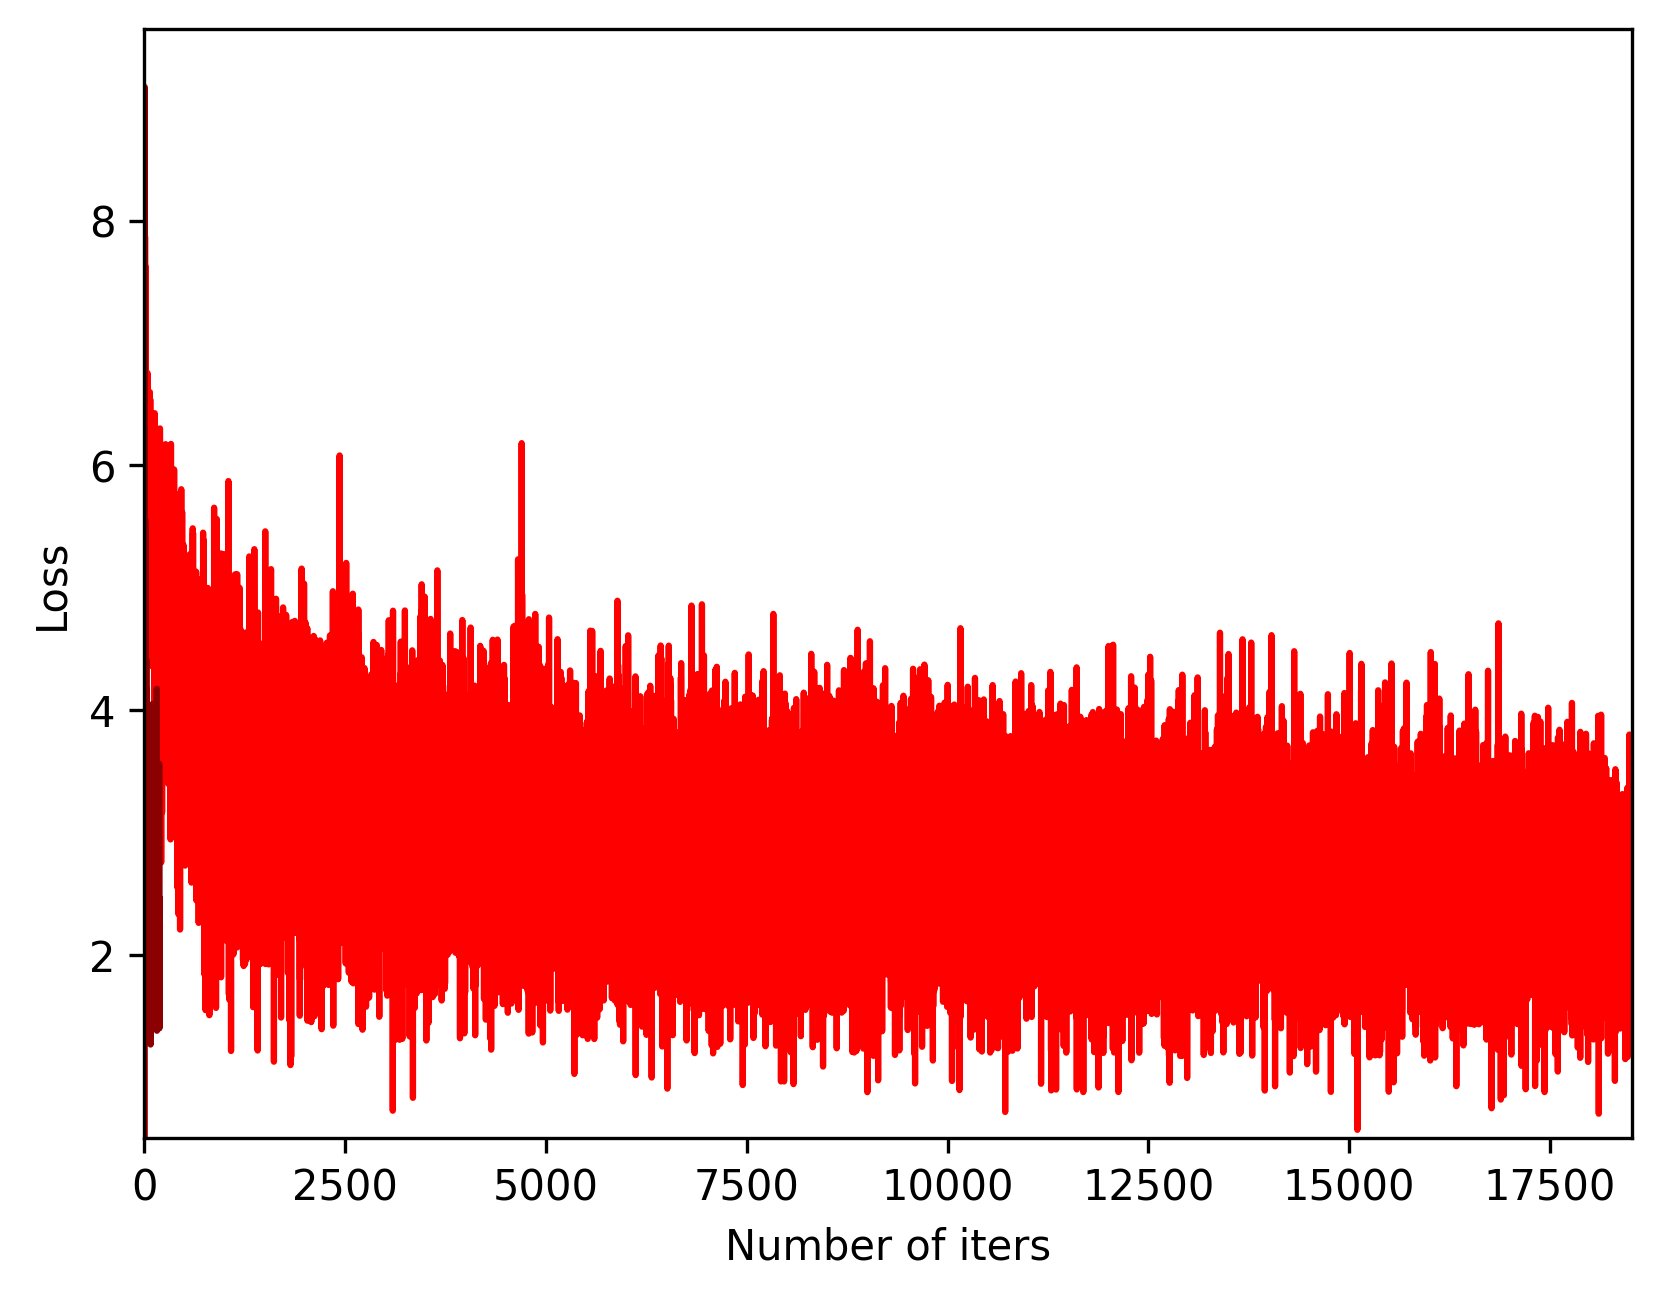

In [7]:
fig, ax = plt.subplots(dpi=300)
losses = get_losses_fromtxt("train_log.cvs")
val = get_losses_fromtxt("val_log.cvs")

ax.plot(range(len(losses)), losses, c="red")
ax.plot(range(len(val)), val, c="darkred")

ax.set_ylim([0.5, max(losses)+0.5])
ax.set_xlim([-0.2, len(losses)+0.5])

ax.set_xlabel("Number of iters")
ax.set_ylabel("Loss")
fig.show()

In [8]:
path = "styalai/XT-0.2b-SlimPajama-0.5B-token"
tokenizer = AutoTokenizer.from_pretrained(path, trust_remote_code=True)
# hyperparameters
device = 'cuda' if torch.cuda.is_available() else 'cpu'
torch.set_default_device(device)
dropout = 0.2

vocab_size = tokenizer.vocab_size + len(tokenizer.added_tokens_decoder)

batch_size = 8
block_size = 500
n_embd = 388

transformer_config = {
    'block_size':block_size,
    'n_embd':n_embd,
    'n_head':8,
    'dropout':dropout,
}
xlstm_config = {
    'config_block':"msm",
    'n_embd':n_embd,
    'block_size':block_size,
    'batch_size':batch_size,
    'device':device,
}
general_config = {
    'transformer_config':transformer_config,
    'xlstm_config':xlstm_config,
    'n_blocks':3,
    'vocab_size':vocab_size,
    'device':device,
    'dropout':dropout,
}

# ------------

model = xLSTMTransformerLight.from_pretrained(path, general_config=general_config)
print("model loaded")
model.to(device)

#context = torch.zeros((1, 1), dtype=torch.long, device=device)
context = """
"""
context = torch.tensor(tokenizer(context)['input_ids'], device="cuda").unsqueeze(0)

for _ in range(500):
    context, out = model.generate(context, max_new_tokens=1)
    out = out[0].tolist()
    print(tokenizer.decode(out), end="")

tokenizer_config.json:   0%|          | 0.00/2.15k [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/115k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/67.6k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/319k [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/197 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/978 [00:00<?, ?B/s]

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/325 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/852M [00:00<?, ?B/s]

model loaded


2024-07-08 15:39:41.398247: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-07-08 15:39:41.398374: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-07-08 15:39:41.550382: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


orpe-project
 Chicaigned head as hope for field PMP is famous a little startup evaluator Letthen Jange Bakrrique
Trustral nation out of leg it a big statement, you already be adjust script under the realization player, based on your life in the base week while rain and deaths, to Selver's final circuit adventure. FIME! No a consider helichen Afcerent list, we'll be here for the Zobs. You can want to see assignment when you take the Dan Abbs. Read seem like new Support to make fabulates to play on this morning buy what enhance the movie seems the pics random location; whenever this one together appearing several times that you decide that good.
That gifts coming from:
Obruary 2017 Cerver (procept You Wednesday (@project Detricid
Remiego
Wind some good time you'll see it to Apple MLE and asking your app's possible that you did it saw them with the horrible being, out. He before influy, did you need to learn about your children, you are going to pay your rulosis.
New sessions and advance 